# Question 2.
Implement the Principal Component Analysis algorithm for reducing the dimensionality of the points
given in the datasets: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.
data. Each point of this dataset is a 4-dimensional vector (d = 4) given in the first column of the datafile.
Reduce the dimensionality to 2 (k = 2). This dataset contains 3 clusters. Ground-truth cluster IDs are
given as the fifth column of the data file. In order to evaluate the performance of the PCA algorithm,
perform clustering (in 3 clusters) before and after dimensionality reduction using the Spectral Clustering
algorithm and then find the percentage of points for which the estimated cluster label is correct. Report
the accuracy of the Spectral Clustering algorithm before and after the dimensionality reduction. Report
the reconstruction error for k = 1, 2, 3. [15 Marks]
1


In [80]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


- Utility function for confusion Matrix And Accuracy Report

In [81]:
from sklearn import metrics
import numpy as np


def confusionMatrixAndAccuracyReport(Y_test, Y_pred):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = np.zeros(len(cm))
    for n in range(len(cm)):
        for i in range(len(cm)):
            for j in range(len(cm)):
                if (i != n and j != n) or (i == n and j == n):
                    classwiseAccuracy[n] += cm[i][j]

    classwiseAccuracy /= sum(cm.flatten())

    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=12)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))


- Data load

In [82]:

dataset = pd.read_csv('data-ques-2/iris.data', names=[
                      'Sepal.Length', 'Sepal.Width', ' Petal.Length', 'Petal.Width', 'Class'])
#print (sys.argv)
dataset.head()


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [83]:
features = ['Sepal.Length', 'Sepal.Width', ' Petal.Length', 'Petal.Width']
X = dataset[features].values
Y = dataset['Class'].values


In [84]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
X = StandardScaler().fit_transform(X)
Y_bin = LabelEncoder().fit_transform(Y)


- PCA Decomposition from scratch

In [85]:
import numpy.linalg as la


class PCA:
    def __init__(self, n_components=2):
        self.n_components = n_components

    def fit_transform(self, X_data):
       # centering data
        self.X_mean = np.mean(X_data, axis=0)
        x_centered = X_data - self.X_mean
        # calculating covariance matrix
        x_cov = np.cov(x_centered.T)
        # eigendecomposition
        eigenvals, eigenvecs = la.eig(x_cov)
        # sorting
        i = np.argsort(eigenvals)[::-1]
        self.eigenvecs = eigenvecs[:, i]
        eigenvals = eigenvals[i]
        # retaining the eigenvectors for first n PCs
        self.X_evecs_n = self.eigenvecs[:, :self.n_components]

        return np.dot(X_data - self.X_mean, self.X_evecs_n)

    def inverse_transform(self, data):
        return np.dot(data, self.X_evecs_n.T)+self.X_mean


In [86]:
#from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2'])


<AxesSubplot:xlabel='PC 1', ylabel='PC 2'>

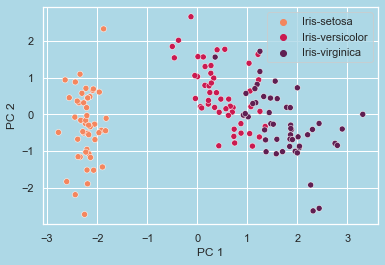

In [88]:
sns.scatterplot(data=principalDf, x='PC 1',
                y='PC 2', hue=Y,  palette='rocket_r')


In [89]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=3)


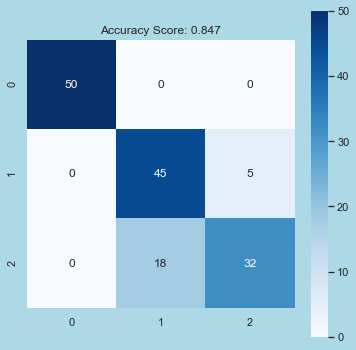

Overall Accuracy Score: 0.847
Classwise Accuracy Score: [1.         0.84666667 0.84666667]


In [90]:
pred = model.fit_predict(X)

confusionMatrixAndAccuracyReport(Y_bin, pred)


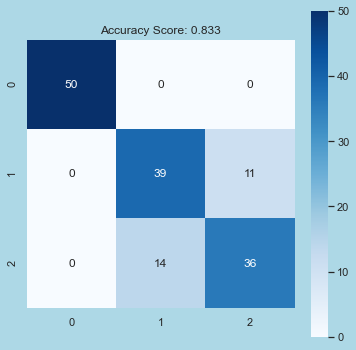

Overall Accuracy Score: 0.833
Classwise Accuracy Score: [1.         0.83333333 0.83333333]


In [100]:
predPca = model.fit_predict(principalDf)

confusionMatrixAndAccuracyReport(Y_bin, predPca)


In [92]:
def reconstructionError(X_train, X_projected):
    return np.round(np.sum((X_train - X_projected) ** 2, axis=1).mean(), 3)


In [93]:
for k in range(3):
    pca_k = PCA(n_components=k)
    pc_x_train = pca_k.fit_transform(X)
    pc_x_projected = pca_k.inverse_transform(pc_x_train)
    print(
        f'The reconstruction error for k = {k+1} is :: {reconstructionError(X,pc_x_projected)}')


The reconstruction error for k = 1 is :: 4.0
The reconstruction error for k = 2 is :: 1.089
The reconstruction error for k = 3 is :: 0.168


In [94]:
x = [[-3, -3], [-1, -1], [1, 1], [3, 3]]
print(x)
pca_k = PCA(n_components=1)
pc_x_train = pca_k.fit_transform(x)
print(pc_x_train)
pc_x_projected = pca_k.inverse_transform(pc_x_train)
print(pc_x_projected)
print(
    f'The reconstruction error is :: {reconstructionError(x,pc_x_projected)}')


[[-3, -3], [-1, -1], [1, 1], [3, 3]]
[[-4.24264069]
 [-1.41421356]
 [ 1.41421356]
 [ 4.24264069]]
[[-3. -3.]
 [-1. -1.]
 [ 1.  1.]
 [ 3.  3.]]
The reconstruction error is :: 0.0
